In [1]:
import torch
import torch_geometric
import torch.nn as nn
from e3nn.o3 import FullyConnectedTensorProduct
import numpy as np
import matplotlib.pyplot as plt

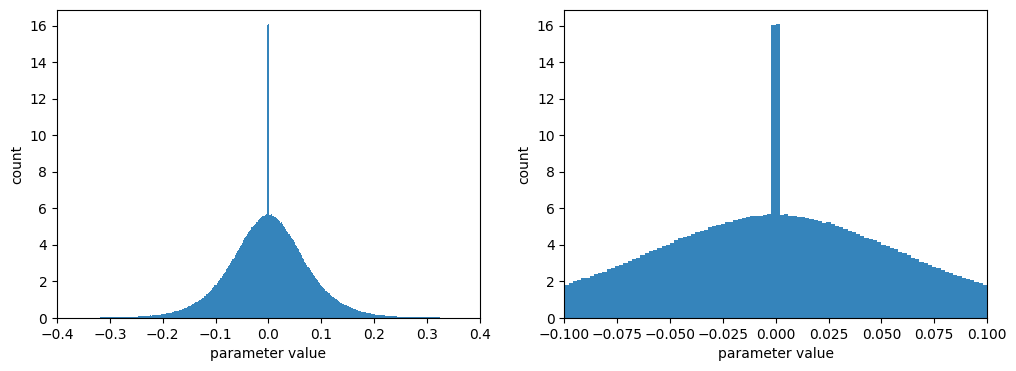

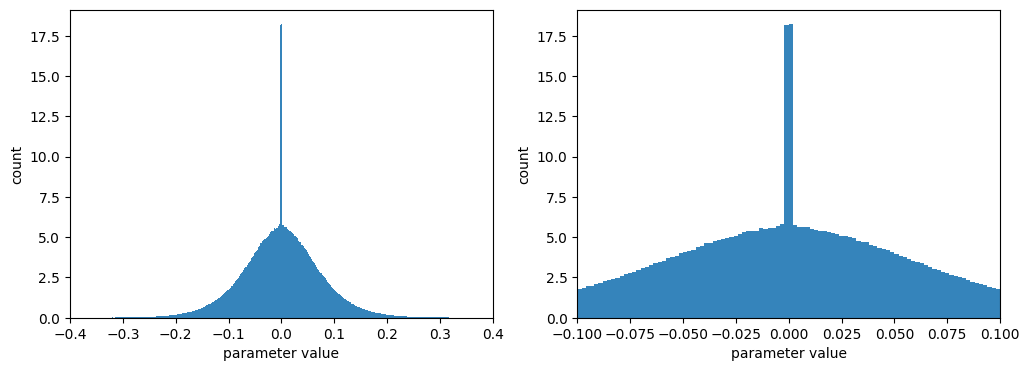

In [7]:
def inspect_distr(seq_num):
    """
    Inspect the distribution of all trained parameters.
    
    ------------
    seq_num: str or int
        the 5-digit sequence string representing a trained model
    """

    # load trained parameters
    trained_paras = torch.load('/mnt/workspace/linchen/nanxiang/my_segnn/equiformer/saved_models/equiformer_' + str(seq_num) + '.pt')
    
    # (!) In case the model is obtained from torch.nn.utils.prune, this ensures modules have the right parameters
    modified_trained_paras = trained_paras.copy()
    for k, v in trained_paras.items():
        if k.endswith(".tp.weight_orig"):
            new_k = k.replace(".tp.weight_orig", ".tp.weight")
            mask_key = k.replace(".tp.weight_orig", ".tp.weight_mask")
            mask = trained_paras[mask_key].detach().cpu()
            zero_mask = torch.nonzero(mask==0)  # return indices of zeros
            v[zero_mask] = 0
            modified_trained_paras[new_k] = v
    trained_paras = modified_trained_paras
    keys_to_remove = [k for k in modified_trained_paras if k.endswith(".tp.weight_orig") or k.endswith(".tp.weight_mask")]
    for k in keys_to_remove:
        del trained_paras[k]

    tensor_collection = []
    for k, v in trained_paras.items():
        if "tp.weight" in k:
            tensor_collection.append(v)

    all_entries = []
    for tensor in tensor_collection:
        all_entries.extend(tensor.flatten().tolist())
    
    bin_width = 0.002
    # add -1 and 1 to collect all values outside (-0.4, 0.4)
    bin_edges = [-1] + list(np.arange(-0.4, 0.4 + bin_width, bin_width)) + [1]

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(all_entries, density=True, bins = bin_edges, alpha=0.9)
    plt.xlim(-0.4, 0.4)
    plt.xlabel("parameter value")
    plt.ylabel("count")

    plt.subplot(1, 2, 2)
    plt.hist(all_entries, density=True, bins = bin_edges, alpha=0.9)
    plt.xlim(-0.1, 0.1)
    plt.xlabel("parameter value")
    plt.ylabel("count")
    
    plt.show()



# inspect_distr(109074)  # baseline
inspect_distr(159918)  # L1=1e-5
# inspect_distr(925805)  # L1=1e-4

dict_keys(['atom_embed.atom_type_lin.tp.weight', 'edge_deg_embed.exp.tp.weight', 'edge_deg_embed.dw.tp.weight', 'edge_deg_embed.proj.tp.weight', 'blocks.0.ga.merge_src.tp.weight', 'blocks.0.ga.merge_dst.tp.weight', 'blocks.0.ga.sep_act.dtp.tp.weight', 'blocks.0.ga.sep_act.lin.tp.weight', 'blocks.0.ga.sep_alpha.tp.weight', 'blocks.0.ga.sep_value.dtp.tp.weight', 'blocks.0.ga.sep_value.lin.tp.weight', 'blocks.0.ga.proj.tp.weight', 'blocks.0.ffn.fctp_1.tp.weight', 'blocks.0.ffn.fctp_2.tp.weight', 'blocks.1.ga.merge_src.tp.weight', 'blocks.1.ga.merge_dst.tp.weight', 'blocks.1.ga.sep_act.dtp.tp.weight', 'blocks.1.ga.sep_act.lin.tp.weight', 'blocks.1.ga.sep_alpha.tp.weight', 'blocks.1.ga.sep_value.dtp.tp.weight', 'blocks.1.ga.sep_value.lin.tp.weight', 'blocks.1.ga.proj.tp.weight', 'blocks.1.ffn.fctp_1.tp.weight', 'blocks.1.ffn.fctp_2.tp.weight', 'blocks.2.ga.merge_src.tp.weight', 'blocks.2.ga.merge_dst.tp.weight', 'blocks.2.ga.sep_act.dtp.tp.weight', 'blocks.2.ga.sep_act.lin.tp.weight', 'bloc

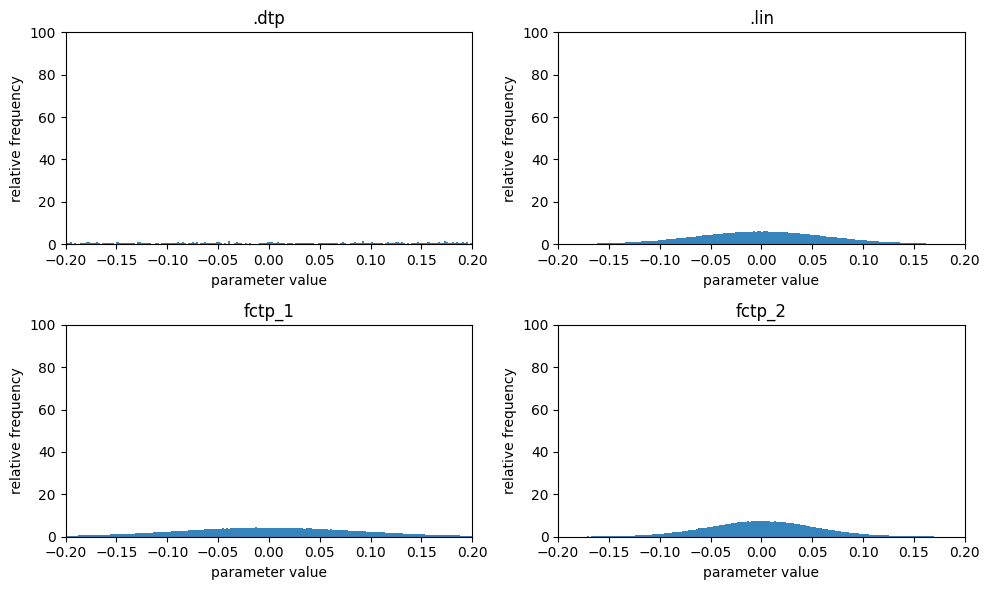

In [13]:
def inspect_layer_distr(seq_num):
    """
    Inspect the distribution of trained parameters within each type of layers separately.
    
    ------------
    seq_num: str or int
        the 6-digit sequence string representing a trained model
    """
    
    # load trained parameters
    trained_paras = torch.load('/mnt/workspace/linchen/nanxiang/my_segnn/equiformer/saved_models/equiformer_' + str(seq_num) + '.pt')
            
    # (!) In case the model is obtained from torch.nn.utils.prune, this ensures modules have the right parameters
    modified_trained_paras = trained_paras.copy()
    for k, v in trained_paras.items():
        if k.endswith(".tp.weight_orig"):
            new_k = k.replace(".tp.weight_orig", ".tp.weight")
            mask_key = k.replace(".tp.weight_orig", ".tp.weight_mask")
            mask = trained_paras[mask_key].detach().cpu()
            zero_mask = torch.nonzero(mask==0)  # return indices of zeros
            v[zero_mask] = 0
            modified_trained_paras[new_k] = v
    trained_paras = modified_trained_paras
    keys_to_remove = [k for k in modified_trained_paras if k.endswith(".tp.weight_orig") or k.endswith(".tp.weight_mask")]
    for k in keys_to_remove:
        del trained_paras[k]
    
    layer_weight_dict = {}
    for k, v in trained_paras.items():
        if "tp.weight" in k:
            layer_weight_dict[k] = v
    
    # check layer names
    print(layer_weight_dict.keys(), end='\n')

    pooled_layer_weight_dict = {'.dtp':[], '.lin':[], 'fctp_1':[], 'fctp_2':[]}
    for k, v in layer_weight_dict.items():
        for name in pooled_layer_weight_dict.keys():
            if name in k:
                pooled_layer_weight_dict[name].extend(v.flatten().tolist())
    
    num_rows = len(pooled_layer_weight_dict) // 2
    if len(pooled_layer_weight_dict) % 2 != 0:
        num_rows += 1
    
    fig, axs = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows), tight_layout=True)
    
    bin_width = 0.002
    # add -1 and 1 to collect all values outside (-0.4, 0.4)
    bin_edges = [-1] + list(np.arange(-0.4, 0.4 + bin_width, bin_width)) + [1]
    
    for idx, (key, value) in enumerate(pooled_layer_weight_dict.items()):
        row = idx // 2
        col = idx % 2
        axs[row, col].hist(value, density=True, bins=bin_edges, alpha=0.9)
        axs[row, col].set_xlim(-0.2, 0.2)
        axs[row, col].set_ylim(0, 100)
        axs[row, col].set_xlabel('parameter value')
        axs[row, col].set_ylabel('relative frequency')
        axs[row, col].set_title(key)
        
    plt.show()



inspect_layer_distr(109074)  # baseline
# inspect_layer_distr(159918)  # L1=1e-5
# inspect_layer_distr(925805)  # L1=1e-4

In [355]:
"""A quick example that illustrates the main idea for `inspect_type_distr` below."""
from e3nn.o3 import Irreps

class O3TensorProduct(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        self.tp = FullyConnectedTensorProduct(
            irreps_in1=Irreps('1x1e + 1x0e'),
            irreps_in2=Irreps('1x1e + 1x0e'),
            irreps_out=Irreps('2x0e + 3x1e'),
            internal_weights = True,
            shared_weights = True
        )
        print(self.tp)

layer1 = O3TensorProduct()
print(list(layer1.named_parameters()))
print('\n')
    
for w in layer1.tp.weight_views(yield_instruction=True):
    print(w[1], w[2], sep='\n')
    print('\n')

print(layer1.tp.irreps_out[w[1][2]].ir.l)

FullyConnectedTensorProduct(1x1e+1x0e x 1x1e+1x0e -> 2x0e+3x1e | 13 paths | 13 weights)
[('tp.weight', Parameter containing:
tensor([-0.2428, -0.3507, -0.4021, -0.2266,  0.0921, -0.7783,  0.9674, -1.8263,
        -0.3117, -0.5236,  1.6545, -0.1289, -0.8144], requires_grad=True))]


Instruction(i_in1=0, i_in2=0, i_out=0, connection_mode='uvw', has_weight=True, path_weight=0.7071067811865476, path_shape=(1, 1, 2))
tensor([[[-0.2428, -0.3507]]], grad_fn=<ViewBackward0>)


Instruction(i_in1=0, i_in2=0, i_out=1, connection_mode='uvw', has_weight=True, path_weight=1.0, path_shape=(1, 1, 3))
tensor([[[-0.4021, -0.2266,  0.0921]]], grad_fn=<ViewBackward0>)


Instruction(i_in1=0, i_in2=1, i_out=1, connection_mode='uvw', has_weight=True, path_weight=1.0, path_shape=(1, 1, 3))
tensor([[[-0.7783,  0.9674, -1.8263]]], grad_fn=<ViewBackward0>)


Instruction(i_in1=1, i_in2=0, i_out=1, connection_mode='uvw', has_weight=True, path_weight=1.0, path_shape=(1, 1, 3))
tensor([[[-0.3117, -0.5236,  1.6545]]]

(0e, 0e, 0e): 0.2382373321361649
(1e, 0e, 1e): 0.4432512744486059
(2e, 0e, 2e): 0.43088978015448604
(0e, 1e, 1e): 0.6705729166666666
(0e, 2e, 2e): 0.5533854166666666
(1e, 1e, 0e): 0.23958333333333334
(1e, 1e, 1e): 0.6692708333333334
(1e, 1e, 2e): 0.5625
(1e, 2e, 1e): 0.5833333333333334
(1e, 2e, 2e): 0.5677083333333334
(2e, 1e, 1e): 0.625
(2e, 1e, 2e): 0.6302083333333334
(2e, 2e, 0e): 0.1875
(2e, 2e, 1e): 0.6302083333333334
(2e, 2e, 2e): 0.5416666666666666


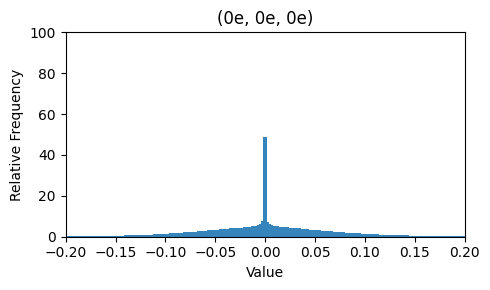

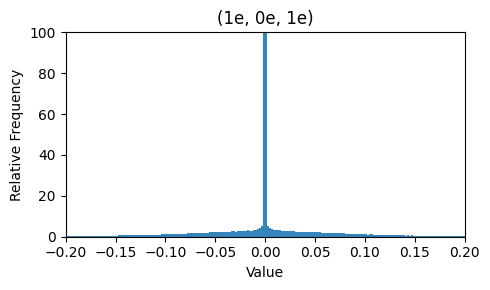

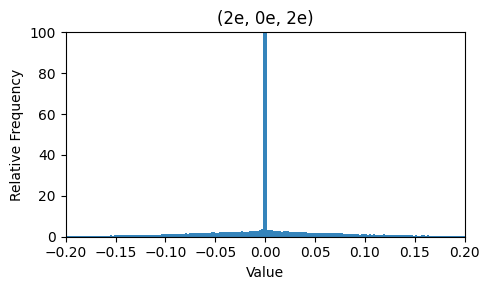

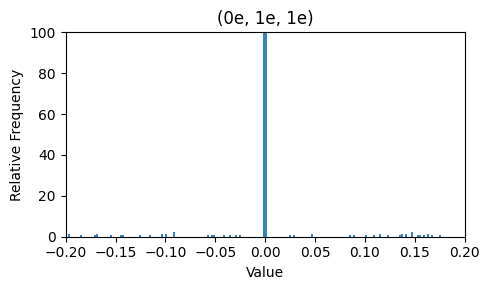

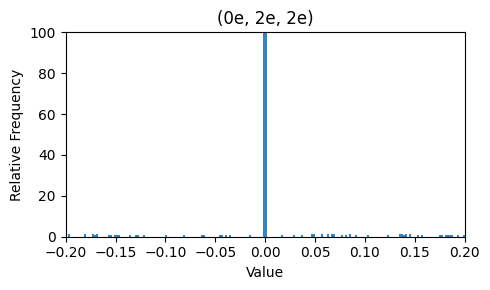

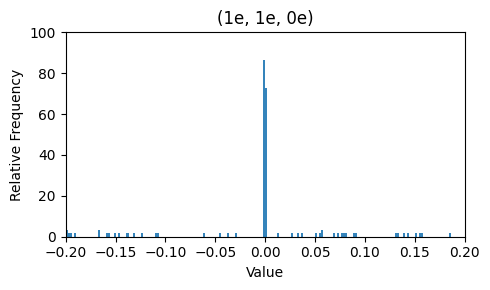

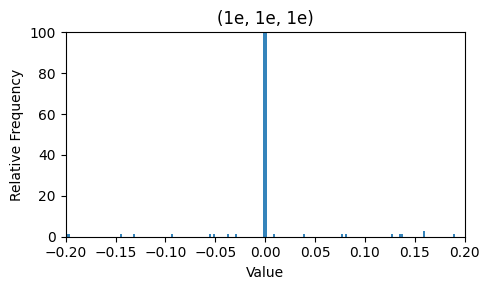

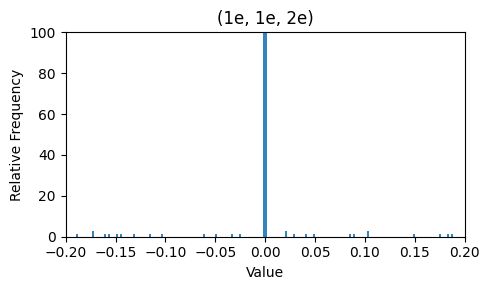

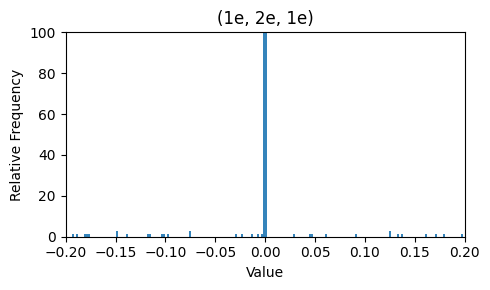

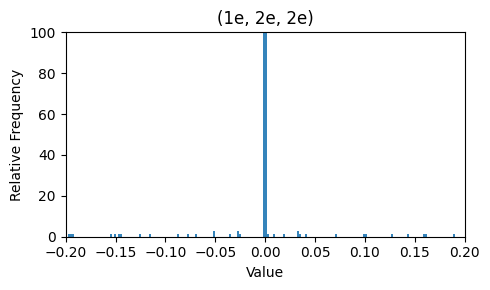

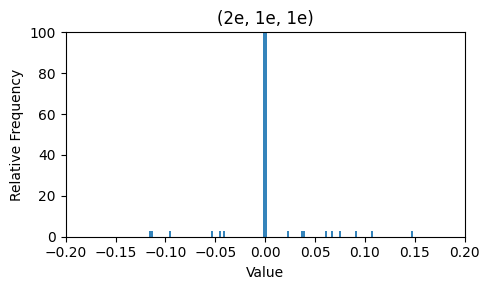

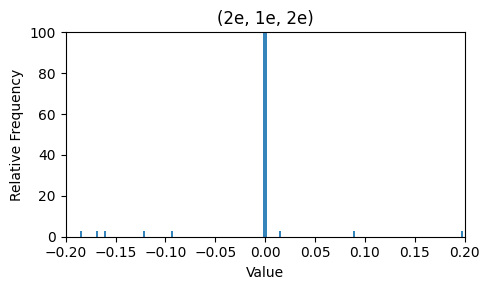

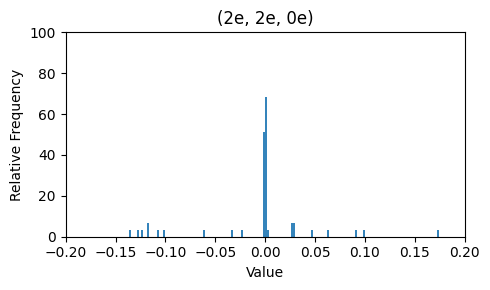

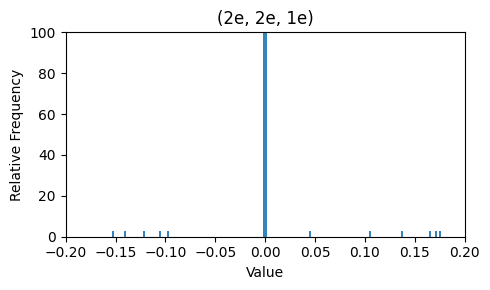

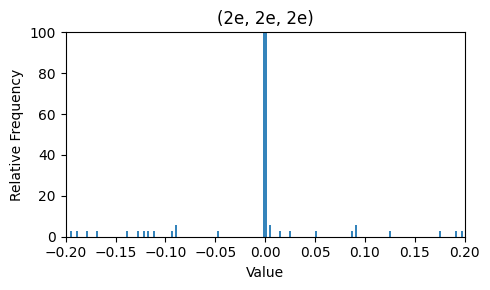

In [39]:
from e3nn.o3 import Irreps
import sys
sys.path.append("..")
from nets import model_entrypoint

def inspect_type_distr(seq_num, name, lmax_h = 2, lmax_attr = 3):
    """
    Inspect the distribution of trained parameters separately for each distinct (l_in1, l_in2, l_out) tuple.
    
    ------------
    seq_num: str or int
        the 6-digit sequence string representing a trained model
    name: str
        name for the setting
    """
    
    # load trained parameters
    trained_paras = torch.load('/mnt/workspace/linchen/nanxiang/my_segnn/equiformer/saved_models/equiformer_' + str(seq_num) + '.pt')
    
    # check which layers contain tp.weight
    # layer_names = []
    # for k, v in trained_paras.items():
    #     if k.endswith(".tp.weight"):
    #         layer_names.append(k[:-len(".tp.weight")])
    # print(layer_names)
    
    # create an empty model of conformable shape
    create_model = model_entrypoint('graph_attention_transformer_nonlinear_l2')
    model = create_model(irreps_in='5x0e', 
        radius=5.0, num_basis=128, 
        out_channels=1, 
        task_mean=75.28121948242188, 
        task_std=8.177621841430664, 
        atomref=None,
        drop_path=0.0)
    
    # (!) In case the model is obtained from torch.nn.utils.prune, this ensures modules have the right parameters
    modified_trained_paras = trained_paras.copy()
    for k, v in trained_paras.items():
        if k.endswith(".tp.weight_orig"):
            new_k = k.replace(".tp.weight_orig", ".tp.weight")
            mask_key = k.replace(".tp.weight_orig", ".tp.weight_mask")
            mask = trained_paras[mask_key].detach().cpu()
            zero_mask = torch.nonzero(mask==0)  # return indices of zeros
            v[zero_mask] = 0
            modified_trained_paras[new_k] = v
    trained_paras = modified_trained_paras
    keys_to_remove = [k for k in modified_trained_paras if k.endswith(".tp.weight_orig") or k.endswith(".tp.weight_mask")]
    for k in keys_to_remove:
        del trained_paras[k]
    
    
    # load model using trained parameters
    model.load_state_dict(trained_paras)
    
    # record all the layers that contain tp.weight
    layers = []
    
    for block in model.blocks:
        layers.append(block.ffn.fctp_1)
        layers.append(block.ffn.fctp_2)
        # layers.append(block.ga.merge_dst)    
        # layers.append(block.ga.sep_alpha)
        layers.append(block.ga.sep_value.dtp)
        layers.append(block.ga.sep_value.lin)
        layers.append(block.ga.proj)
    
    # categorize entries based on their in_out_type
    in_out_type_weight_dict = {}
    for layer in layers:
        for w in layer.tp.weight_views(yield_instruction=True):
            # w[1] is instruction; w[2] is weight_view
            # the first three entries of instruction are indices of the corresponding irreps used in tp: (in1, in2, out)
            # layer.tp.irreps_in1[w[1][0]] return an MulIr object (e.g. 2x1e) and .ir obtains type with parity
            l_in1 = layer.tp.irreps_in1[w[1][0]].ir
            l_in2 = layer.tp.irreps_in2[w[1][1]].ir
            l_out = layer.tp.irreps_out[w[1][2]].ir
            in_out_tuple = (l_in1, l_in2, l_out)
            
            if in_out_tuple not in in_out_type_weight_dict.keys():
                in_out_type_weight_dict[in_out_tuple] = []
            
            in_out_type_weight_dict[in_out_tuple].extend(w[2].flatten().tolist())
            # print(w)
    
    # print(in_out_type_weight_dict.keys())
    
    count_threshold = 0.005
    for key, value in in_out_type_weight_dict.items():
        sparsity = len([v for v in value if abs(v) < count_threshold]) / len(value)
        print(key, ": ", sparsity, sep='')
    
    bin_width = 0.002
    # add -1 and 1 to collect all values outside (-0.4, 0.4)
    bin_edges = [-1] + list(np.arange(-0.4, 0.4 + bin_width, bin_width)) + [1]

    # Iterate through the dictionary items
    for key, value in in_out_type_weight_dict.items():
        plt.figure(figsize=(5, 3))
        
        plt.hist(value, density=True, bins=bin_edges, alpha=0.9)
        
        plt.xlabel('Value')
        plt.xlim(-0.2, 0.2)
        plt.ylabel('Relative Frequency')
        plt.ylim(0, 100)
        plt.title(key)
        
        # plt.savefig("/mnt/workspace/linchen/nanxiang/my_segnn/model_performance/pictures/"+f"{name}_{key}.pdf", bbox_inches='tight')

        plt.tight_layout()
        plt.show()
        
        

# inspect_type_distr(109074, name="trial")  # baseline
# inspect_type_distr(857309, name="trial")  # L1=5e-5
# inspect_type_distr(469518, name="trial")  # L1=5e-4
inspect_type_distr(433190, name="trial")  # L1=5e-3